### Summary
In this notebook we will query European Air Quality data from the Fraunhofer Institute.
These data are reliable as Fraunhofer Institute gets them from official national / regional agencies.
These are themselves a good example of interoperability as the institute managed to put them together and made them available using the SensorThings standard.

In this notebook we will:
* Request data from the API
* Put them into a Pandas DataFrame
* Transform it into a GeoDataFrame
* Plot the data with a background map and color the point according to the value of a pollutant

In [1]:
import requests
import pandas as pd
import json
import geopandas as gpd
import contextily as cx

In [2]:
#Install libraries if necessary with 
#pip install 
#or !pip install

In [5]:
#INPUT PARAMETERS (REMEMBER TO FIX THIS AS YOU NEED!)
dt = "2023-06-27T00:00:00.000Z" #starting date of the data

In [6]:
#REQUESTS
# We are requesting so many data that the requests is only giving us back the first 100 locations (around Austria)
response = requests.get(
    "https://airquality-frost.k8s.ilt-dmz.iosb.fraunhofer.de/v1.1/Locations?$expand=Things/Datastreams/Observations($select=phenomenonTime,result;$filter=phenomenonTime%20ge%202023-06-26T16:00:00.000Z)"
)

In [7]:
#The data are structured in a nested JSON
data_json = response.json()
data_json

{'value': [{'@iot.selfLink': 'https://airquality-frost.k8s.ilt-dmz.iosb.fraunhofer.de/v1.1/Locations(1)',
   '@iot.id': 1,
   'name': 'Liesing - Gewerbegebiet',
   'description': 'Location of air quality station Liesing - Gewerbegebiet',
   'encodingType': 'application/geo+json',
   'location': {'type': 'Point', 'coordinates': [16.30127778, 48.14125]},
   'properties': {'owner': 'http://luft.umweltbundesamt.at',
    'localId': 'STA.09.LIES',
    'metadata': 'http://luft.umweltbundesamt.at/inspire/wfs?service=WFS&version=2.0.0&request=GetFeature&typeName=aqd:AQD_Station',
    'namespace': 'AT.0008.20.AQ',
    'countryCode': 'AT'},
   'Things': [{'@iot.selfLink': 'https://airquality-frost.k8s.ilt-dmz.iosb.fraunhofer.de/v1.1/Things(1)',
     '@iot.id': 1,
     'name': 'Liesing - Gewerbegebiet',
     'description': 'Air quality station Liesing - Gewerbegebiet',
     'properties': {'owner': 'http://luft.umweltbundesamt.at',
      'mobile': False,
      'localId': 'STA.09.LIES',
      'metad

In [8]:
#Creating a list of lists with the data from the json
list_tmp = []

for location in data_json['value']:
    for thing in location['Things']:
        for datastream in thing['Datastreams']:
            for observation in datastream['Observations']:

                list_tmp.append([
                    location['name'],
                    location['location']['coordinates'][0],  # x
                    location['location']['coordinates'][1],  # y
                    datastream['name'],
                    datastream['description'],
                    observation['phenomenonTime'],
                    observation['result']
                ])

In [9]:
#Creating a pandas DF with the data
df = pd.DataFrame(list_tmp, columns=['location', 'lon', 'lat','obs_prop', "obs_desc", 'timestamp', 'result'])
df

,location,lon,lat,obs_prop,obs_desc,timestamp,result
0,Liesing - Gewerbegebiet,16.301278,48.141250,SPO.09.LIES.5511.5.1,PM10 as Liesing - Gewerbegebiet,2023-06-26T16:00:00Z/2023-06-26T17:00:00Z,9.039101
1,Liesing - Gewerbegebiet,16.301278,48.141250,SPO.09.LIES.5511.5.1,PM10 as Liesing - Gewerbegebiet,2023-06-26T17:00:00Z/2023-06-26T18:00:00Z,9.659650
2,Liesing - Gewerbegebiet,16.301278,48.141250,SPO.09.LIES.5511.5.1,PM10 as Liesing - Gewerbegebiet,2023-06-26T18:00:00Z/2023-06-26T19:00:00Z,12.172000
3,Liesing - Gewerbegebiet,16.301278,48.141250,SPO.09.LIES.5511.5.1,PM10 as Liesing - Gewerbegebiet,2023-06-26T19:00:00Z/2023-06-26T20:00:00Z,11.087999
4,Liesing - Gewerbegebiet,16.301278,48.141250,SPO.09.LIES.5511.5.1,PM10 as Liesing - Gewerbegebiet,2023-06-26T20:00:00Z/2023-06-26T21:00:00Z,11.382500
...,...,...,...,...,...,...,...
12666,Hallein A10 Tauernautobahn,13.108056,47.691111,SPO.05.2300.5876.5.1,PM10 as Hallein A10 Tauernautobahn,2023-06-28T05:00:00Z/2023-06-28T06:00:00Z,9.155000
12667,Hallein A10 Tauernautobahn,13.108056,47.691111,SPO.05.2300.5876.5.1,PM10 as Hallein A10 Tauernautobahn,2023-06-28T06:00:00Z/2023-06-28T07:00:00Z,7.630000
12668,Hallein A10 Tauernautobahn,13.108056,47.691111,SPO.05.2300.5876.5.1,PM10 as Hallein A10 Tauernautobahn,2023-06-28T07:00:00Z/2023-06-28T08:00:00Z,6.610000
12669,Hallein A10 Tauernautobahn,13.108056,47.691111,SPO.05.2300.5876.5.1,PM10 as Hallein A10 Tauernautobahn,2023-06-28T08:00:00Z/2023-06-28T09:00:00Z,0.000000


In [11]:
#Creating a new column "pollutant" copying it from the first part of the column obs_desc
df["pollutant"] = df.obs_desc.str.split(" ").str[0]
df

,location,lon,lat,obs_prop,obs_desc,timestamp,result,pollutant
0,Liesing - Gewerbegebiet,16.301278,48.141250,SPO.09.LIES.5511.5.1,PM10 as Liesing - Gewerbegebiet,2023-06-26T16:00:00Z/2023-06-26T17:00:00Z,9.039101,PM10
1,Liesing - Gewerbegebiet,16.301278,48.141250,SPO.09.LIES.5511.5.1,PM10 as Liesing - Gewerbegebiet,2023-06-26T17:00:00Z/2023-06-26T18:00:00Z,9.659650,PM10
2,Liesing - Gewerbegebiet,16.301278,48.141250,SPO.09.LIES.5511.5.1,PM10 as Liesing - Gewerbegebiet,2023-06-26T18:00:00Z/2023-06-26T19:00:00Z,12.172000,PM10
3,Liesing - Gewerbegebiet,16.301278,48.141250,SPO.09.LIES.5511.5.1,PM10 as Liesing - Gewerbegebiet,2023-06-26T19:00:00Z/2023-06-26T20:00:00Z,11.087999,PM10
4,Liesing - Gewerbegebiet,16.301278,48.141250,SPO.09.LIES.5511.5.1,PM10 as Liesing - Gewerbegebiet,2023-06-26T20:00:00Z/2023-06-26T21:00:00Z,11.382500,PM10
...,...,...,...,...,...,...,...,...
12666,Hallein A10 Tauernautobahn,13.108056,47.691111,SPO.05.2300.5876.5.1,PM10 as Hallein A10 Tauernautobahn,2023-06-28T05:00:00Z/2023-06-28T06:00:00Z,9.155000,PM10
12667,Hallein A10 Tauernautobahn,13.108056,47.691111,SPO.05.2300.5876.5.1,PM10 as Hallein A10 Tauernautobahn,2023-06-28T06:00:00Z/2023-06-28T07:00:00Z,7.630000,PM10
12668,Hallein A10 Tauernautobahn,13.108056,47.691111,SPO.05.2300.5876.5.1,PM10 as Hallein A10 Tauernautobahn,2023-06-28T07:00:00Z/2023-06-28T08:00:00Z,6.610000,PM10
12669,Hallein A10 Tauernautobahn,13.108056,47.691111,SPO.05.2300.5876.5.1,PM10 as Hallein A10 Tauernautobahn,2023-06-28T08:00:00Z/2023-06-28T09:00:00Z,0.000000,PM10


In [12]:
#Filtering the rows, keeping only the measurments of CO (you can do it with all the pollutant)
df_CO = df[(df.pollutant == "CO")]
# The next line is used to download the data as CSV. If you run it, you will find the file in the same folder as the notebook.
#df.to_csv('datiFerrara.csv', index=False)
df_CO

,location,lon,lat,obs_prop,obs_desc,timestamp,result,pollutant
168,Graz Süd Tiergartenweg,15.433056,47.041668,SPO.06.170.5938.10.1,CO as Graz Süd Tiergartenweg,2023-06-26T16:00:00Z/2023-06-26T17:00:00Z,0.209076,CO
169,Graz Süd Tiergartenweg,15.433056,47.041668,SPO.06.170.5938.10.1,CO as Graz Süd Tiergartenweg,2023-06-26T17:00:00Z/2023-06-26T18:00:00Z,0.213269,CO
170,Graz Süd Tiergartenweg,15.433056,47.041668,SPO.06.170.5938.10.1,CO as Graz Süd Tiergartenweg,2023-06-26T18:00:00Z/2023-06-26T19:00:00Z,0.223186,CO
171,Graz Süd Tiergartenweg,15.433056,47.041668,SPO.06.170.5938.10.1,CO as Graz Süd Tiergartenweg,2023-06-26T19:00:00Z/2023-06-26T20:00:00Z,0.228830,CO
172,Graz Süd Tiergartenweg,15.433056,47.041668,SPO.06.170.5938.10.1,CO as Graz Süd Tiergartenweg,2023-06-26T20:00:00Z/2023-06-26T21:00:00Z,0.244519,CO
...,...,...,...,...,...,...,...,...
12203,Sonnblick,12.957778,47.054167,SPO.10.SON1.352.10.1,CO as Sonnblick,2023-06-28T05:00:00Z/2023-06-28T06:00:00Z,0.112908,CO
12204,Sonnblick,12.957778,47.054167,SPO.10.SON1.352.10.1,CO as Sonnblick,2023-06-28T06:00:00Z/2023-06-28T07:00:00Z,0.121056,CO
12205,Sonnblick,12.957778,47.054167,SPO.10.SON1.352.10.1,CO as Sonnblick,2023-06-28T07:00:00Z/2023-06-28T08:00:00Z,0.129204,CO
12206,Sonnblick,12.957778,47.054167,SPO.10.SON1.352.10.1,CO as Sonnblick,2023-06-28T08:00:00Z/2023-06-28T09:00:00Z,0.124548,CO


In [13]:
# Get the max value of CO for each location
# You can also perform other functions, like mean, min, sum, ...
df_CO_max = df_CO.filter(items=['location', 'lon', 'lat', 'result'])
df_CO_max = df_CO_max.groupby(['location']).max()
df_CO_max.reset_index(inplace=True)
df_CO_max

,location,lon,lat,result
0,Eisenstadt Laschoberstraße,16.528060,47.840000,0.291600
1,Feldkirch Bärenkreuzung,9.597696,47.239445,0.640103
2,Graz Mitte Gries,15.431945,47.069240,0.377922
3,Graz Süd Tiergartenweg,15.433056,47.041668,0.450774
4,Hietzinger Kai,16.300020,48.188372,0.339435
5,Leoben Donawitz Kindergarten,15.074500,47.375556,2.865525
6,Sonnblick,12.957778,47.054167,0.208356
7,St. Pölten Europaplatz HTL,15.620400,48.201300,0.256080
8,"Steyregg Au, Freizeitpark",14.365833,48.278889,2.189550
9,Taborstraße,16.380918,48.216739,0.217896


In [14]:
#From DataFrame to GeoDataFrame
gdf_CO_max = gpd.GeoDataFrame(
    df_CO_max, geometry=gpd.points_from_xy(df_CO_max.lon, df_CO_max.lat), crs="EPSG:4326"
)

gdf_CO_max

,location,lon,lat,result,geometry
0,Eisenstadt Laschoberstraße,16.528060,47.840000,0.291600,POINT (16.52806 47.84000)
1,Feldkirch Bärenkreuzung,9.597696,47.239445,0.640103,POINT (9.59770 47.23945)
2,Graz Mitte Gries,15.431945,47.069240,0.377922,POINT (15.43195 47.06924)
3,Graz Süd Tiergartenweg,15.433056,47.041668,0.450774,POINT (15.43306 47.04167)
4,Hietzinger Kai,16.300020,48.188372,0.339435,POINT (16.30002 48.18837)
5,Leoben Donawitz Kindergarten,15.074500,47.375556,2.865525,POINT (15.07450 47.37556)
6,Sonnblick,12.957778,47.054167,0.208356,POINT (12.95778 47.05417)
7,St. Pölten Europaplatz HTL,15.620400,48.201300,0.256080,POINT (15.62040 48.20130)
8,"Steyregg Au, Freizeitpark",14.365833,48.278889,2.189550,POINT (14.36583 48.27889)
9,Taborstraße,16.380918,48.216739,0.217896,POINT (16.38092 48.21674)


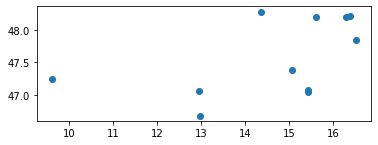

In [15]:
gdf_CO_max.plot();

In [16]:
gdf_CO_max = gdf_CO_max.to_crs(epsg=3857)
gdf_CO_max.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

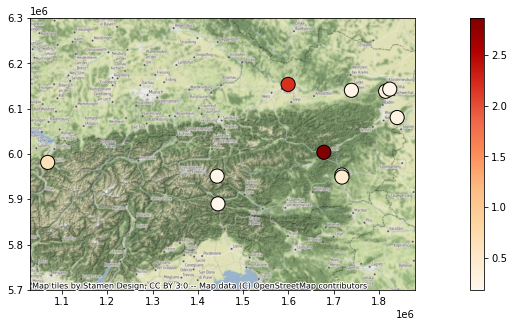

In [17]:
ax = gdf_CO_max.plot(figsize=(20, 5),
                     markersize=200,
                     edgecolor="k",
                     column="result", 
                     cmap='OrRd', 
                     legend = 'true'
                    )
ax.set_ylim(5.7e6,6.3e6)
cx.add_basemap(ax)